In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, N_syl, N_HVC_per_syl = 600, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 8 # Number of renditions
T_burn = 100 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(1, 1, size=(N_syl, NE))#.clip(min=0)
# ( Number of syllables , Number of renditions )
_ = np.arange(0, T - T_burn + T_rend, T_rend) # start and end time of each rendition
# start and end time of each syllabus; inter-rendition interval = duration of a syllabus
_ = np.linspace(_[:-1], _[1:], num=N_syl+1, endpoint=False) + T_burn
tsyl_start, tsyl_end = _[:-1], _[1:]
inter_syl_interval = (tsyl_end - tsyl_start)[0,0] * 0
tsyl_start, tsyl_end = np.round(tsyl_start), np.round(tsyl_end - inter_syl_interval)
# ( Number of HVC neurons , Number of renditions )
burst_ts = np.linspace(tsyl_start[0,:], tsyl_end[-1,:], num=N_HVC, endpoint=True)
# burst_ts += T_rend/(N_syl+1) * 0.1 # a little delay 
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# plt.plot(rH[:T_rend+T_burn])
# plt.plot(tsyl_start[:,0], np.zeros(N_syl) + peak_rate, 'x', c='r')
# plt.plot(tsyl_end[:,0], np.zeros(N_syl) + peak_rate, 'x', c='b')
# plt.plot(burst_ts[:,0], np.zeros(N_HVC) + peak_rate, '|', c='k')

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start.T.flatten(), tsyl_end.T.flatten(), 
                            np.tile(syl, (N_rend, 1)))
aud = aud

In [9]:
JEE, JEI, JIE, JII = np.array([2, 1, 1.5, 0.5]) * 0.3

In [10]:
rE_rest, rI_rest = 1, 5 # target resting rate
rEmax, rImax, sE, sI = 100, 200, 2, 2
thE = -erfinv(rE_rest * 2 / rEmax - 1) * (np.sqrt(2) * sE) \
    + JEE * rE_rest - JEI * rI_rest
thI = -erfinv((rI_rest) * 2 / rImax - 1) * (np.sqrt(2) * sI) \
    + JIE * rE_rest - JII * rI_rest
print(thE, thI)
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

3.752695748081681 3.6199279690801083


In [11]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - rE_rest) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [12]:
w0_mean = 1/N_HVC
w_inh, wI = w0_mean, 0.2
tauE, tauI, dt = 40, 10, 1

net = WCNet(NE, N_HVC, w0_mean, phiE, tauE, 
            phiI=phiI, tauI=tauI, w_inh=w_inh, wI=wI,
            JEE=JEE, JEI=JEI, JIE=JIE, JII=JII)

rE0, rI0 = rE_rest, rI_rest
_ = net.sim(rE0, rH, aud, save_W_ts, T, dt, 0.1, bilin_hebb,
            lr=-5e-2, w0_mean=w0_mean, tauW=1e5, rI0=rI0)
rE, rI, Ws, mean_HVC_input = _

(<Figure size 400x600 with 4 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: ylabel='Mean exc. rate'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean inh. rate'>],
       dtype=object))

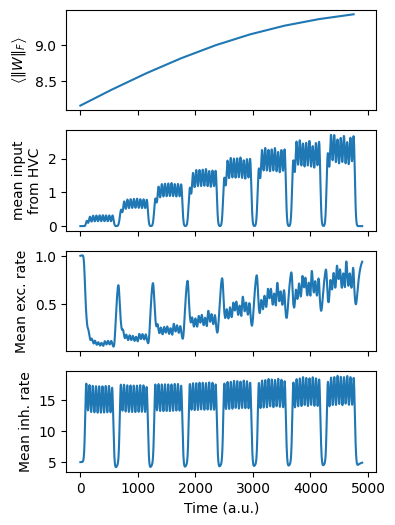

In [13]:
plot_train_stats(Ws, rE, mean_HVC_input, save_W_ts, rI)

In [14]:
W_syl_corrs = [correlation(_.T, syl, dim=2) for _ in Ws]

(<Figure size 600x200 with 4 Axes>,
 array([<Axes: title={'center': 'Rendition 0'}>,
        <Axes: title={'center': 'Rendition 4'}>,
        <Axes: title={'center': 'Rendition 8'}>], dtype=object))

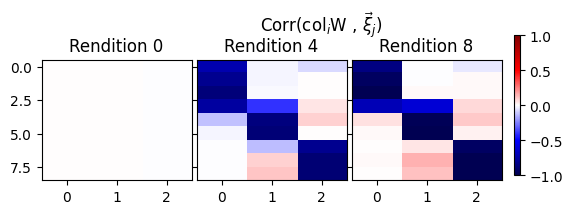

In [15]:
plot_wcol_corr(W_syl_corrs, (1, 3), (6, 2))

(array([2.20910191, 2.68232148, 2.66874283, 2.51647863, 2.58569709,
        2.64135844, 2.45633777, 2.59782981, 2.61081853]),
 3.3333333333333335)

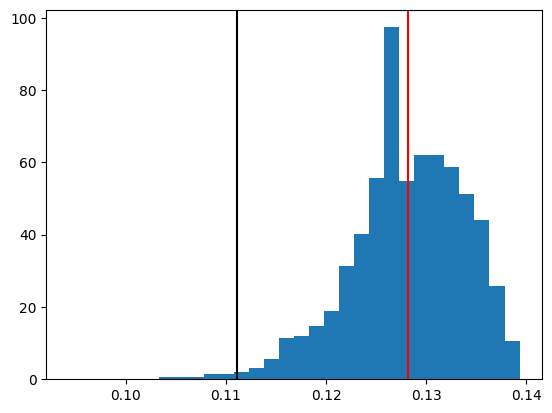

In [16]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')
(Ws[-1][:,:].mean(axis=0) - w_inh) * peak_rate, wI * peak_rate / N_HVC

## Test Model with Unmatched Auditory Feedback

In [17]:
N_rend_test = 5
T_test = T_burn + T_rend * N_rend_test
t_test_start, t_test_end = tsyl_start[:,:N_rend_test], tsyl_end[:,:N_rend_test]
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH_ = generate_HVC(T_test, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
rE0, rI0, noise = rng.normal(loc=rE_rest, scale=0.1, size=NE).clip(min=0), rI_rest, 0

### Mismatch with completely independent patterns

In [18]:
idx_si = np.arange(syl.shape[0]) # shuffle index
syl_sp = syl.copy() # shuffle syllable patterns (randomize)
rng.shuffle(idx_si, axis=0)
while (idx_si == np.arange(len(idx_si))).any():
    rng.shuffle(idx_si, axis=0)
# idx_si[1:5] = np.arange(1, 5)
syl_si = syl[idx_si]
rng.shuffle(syl_sp, axis=1)

aud_si = generate_discrete_aud(T_test, NE, t_test_start.T.flatten(), 
                               t_test_end.T.flatten(), np.tile(syl_si, (N_rend_test, 1)))
aud_sp = generate_discrete_aud(T_test, NE, t_test_start.T.flatten(), 
                               t_test_end.T.flatten(), np.tile(syl_sp, (N_rend_test, 1)))

In [19]:
# plasticity function is None and lr is 0 by default
test0 = net.sim(rE0, rH_, aud[:T_test], [], T_test, dt, noise, rI0=rI0)
test_si = net.sim(rE0, rH_, aud_si, [], T_test, dt, noise, rI0=rI0)
test_sp = net.sim(rE0, rH_, aud_sp, [], T_test, dt, noise, rI0=rI0)
test0, test_si, test_sp = test0[:2], test_si[:2], test_sp[:2] # just want rE and rI

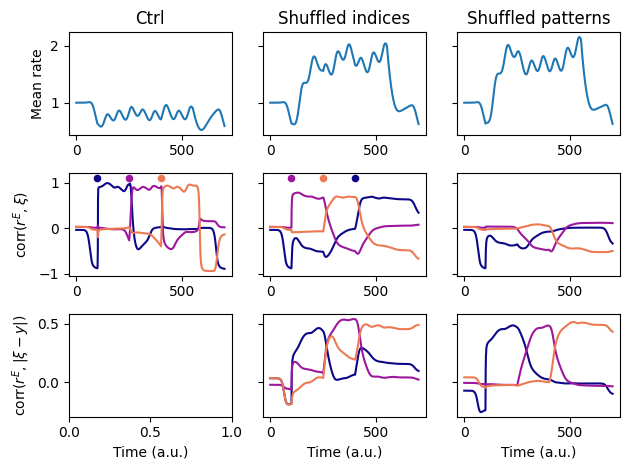

In [20]:
labels = ('Ctrl', 'Shuffled indices', 'Shuffled patterns')
cmap = colormaps.get_cmap('plasma')
fig, ax = plt.subplots(3, 3, sharey='row')
for i, (test, syl_, l) in enumerate(zip((test0, test_si, test_sp), 
                                        (syl, syl_si, syl_sp), labels)):
    corr = correlation(test[0][:T_burn+T_rend], syl, dim=2)
    ax[0,i].plot(test[0][0:T_rend+T_burn].mean(axis=1)[:])
    ax[0,i].set(title=l)
    ax[-1,i].set(xlabel='Time (a.u.)')
    for j in range(corr.shape[1]):
        ax[1,i].plot(corr[:,j], c=cmap(j/corr.shape[1]))
    if i > 0:
        corr = correlation(test[0][:T_burn+T_rend], np.abs(syl - syl_), dim=2)
        for j in range(corr.shape[1]):
            ax[2,i].plot(corr[:,j], c=cmap(j/corr.shape[1]))

for i, j in enumerate(idx_si):
    c1, c2 = cmap(i/len(idx_si)), cmap(j/len(idx_si))
    ax[1,0].scatter(tsyl_start[i,0], 1.1, color=c1, s=20)
    ax[1,1].scatter(tsyl_start[i,0], 1.1, color=c2, s=20)
ax[0,0].set(ylabel='Mean rate')
ax[1,0].set(ylabel=r'corr$(r^E, \xi)$')
ax[2,0].set(ylabel=r'corr$(r^E, |\xi - y|)$')
fig.tight_layout()

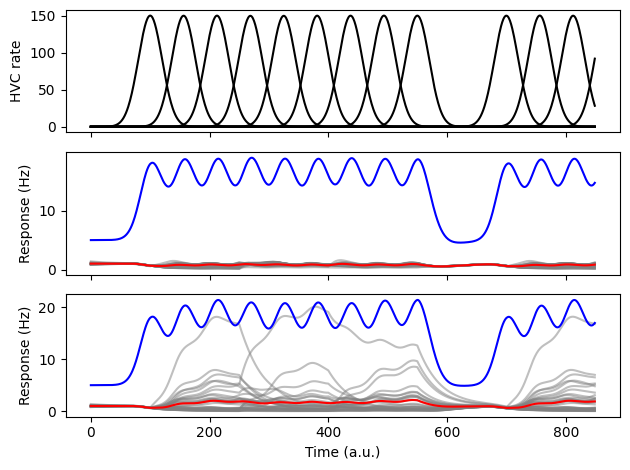

In [21]:
fig, ax = plt.subplots(3, sharex='all')
i, j = 0, int(tsyl_end[0,1])
ax[0].plot(rH[i:j], c='k')
ax[1].plot(test0[0][i:j,:30], c='grey', alpha=0.5)
ax[1].plot(test0[0][i:j,:].mean(axis=-1), c='r')
ax[1].plot(test0[1][i:j], c='b', label='Mean inh. rate')
ax[2].plot(test_sp[0][i:j,:30], c='grey', alpha=0.5)
ax[2].plot(test_sp[0][i:j,:].mean(axis=-1), c='r')
ax[2].plot(test_sp[1][i:j], c='b', label='Mean inh. rate')
ax[0].set(ylabel='HVC rate')
ax[1].set(ylabel='Response (Hz)')
ax[2].set(xlabel='Time (a.u.)', ylabel='Response (Hz)')
fig.tight_layout()

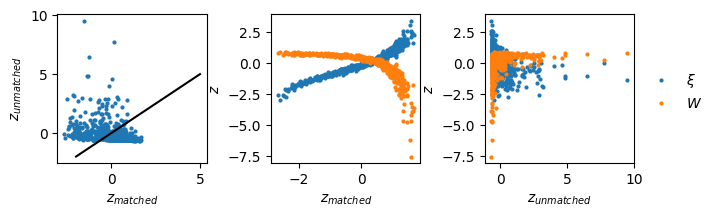

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(7, 2))
i, j = 0, int(tsyl_end[0,0])
ls = (test0[0][i:j,:].mean(axis=0), test_sp[0][i:j,:].mean(axis=0), syl[0], Ws[-1][:,0])
zs = [(l - l.mean(keepdims=True)) / l.std(keepdims=True) for l in ls]
ax[0].plot(zs[0], zs[1], 'o', ms=2)
ax[0].set(xlabel=r'$z_{matched}$', ylabel=r'$z_{unmatched}$')
ax[0].plot([-2, 5], [-2, 5], c='k')
ax[1].plot(zs[0], zs[2], 'o', ms=2, label=r'$\xi$')
ax[1].plot(zs[0], zs[3], 'o', ms=2, label=r'$W$')
ax[1].set(xlabel=r'$z_{matched}$', ylabel='$z$')
ax[2].plot(zs[1], zs[2], 'o', ms=2, label=r'$\xi$')
ax[2].plot(zs[1], zs[3], 'o', ms=2, label=r'$W$')
ax[2].set(xlabel=r'$z_{unmatched}$', ylabel='$z$')
ax[2].legend(frameon=False, bbox_to_anchor=(1., 0.7))
fig.tight_layout(pad=0.1)

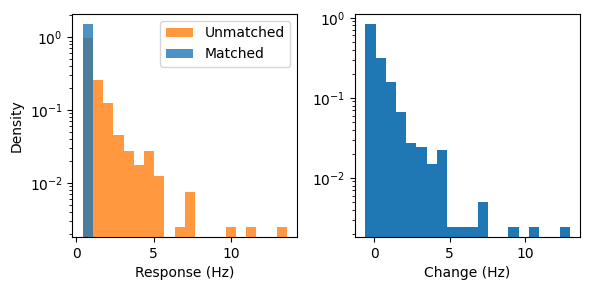

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
m0, m_sp = test0[0][i:j,:].mean(axis=0), test_sp[0][i:j,:].mean(axis=0)
ax[0].hist([m0, m_sp], label=['Matched', 'Unmatched'], bins=20, density=True, 
           histtype='stepfilled', log=True, alpha=0.8)
ax[0].set(xlabel='Response (Hz)', ylabel='Density')
ax[0].legend()
ax[1].hist(m_sp - m0, bins=20, density=True, log=True)
ax[1].set(xlabel='Change (Hz)')
fig.tight_layout()

### Mismatch with perturbed patterns

In [24]:
perturb_type = 'SNR'
# perturb_type = 'ADD'
perturb_param = np.linspace(0, 1, num=11) 
tests, ovlps, corrs = [], [], []

for pm in perturb_param:
    eps = rng.standard_normal(size=syl.shape)
    syl_ = syl.copy()
    if perturb_type == 'SNR':
        mean_syl, std_syl = syl.mean(), syl.std()
        syl_ = (syl - mean_syl) / std_syl * (1 - pm) + np.sqrt(pm * (2 - pm)) * eps
        syl_ = syl_ * std_syl + mean_syl
    elif perturb_type == 'ADD':
        syl_ = syl + pm * eps
    else:
        raise NotImplementedError
    aud_ = generate_discrete_aud(T_test, NE, t_test_start.T.flatten(), 
                                 t_test_end.T.flatten(), np.tile(syl_, (N_rend_test, 1)))
    tests.append(net.sim(rE0, rH_, aud_, [], T_test, dt, noise, rI0=rI0))
    ovlps.append(tests[-1][-0] @ syl.T)
    corrs.append(correlation(tests[-1][0], syl, dim=2))

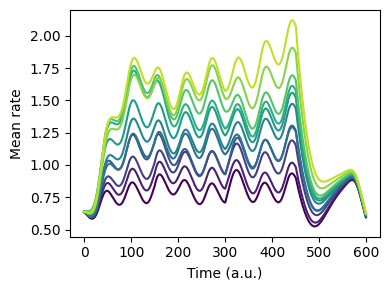

In [25]:
fig, ax = plt.subplots(1, sharey='all', sharex='all', figsize=(4, 3))
# for i in range(ax.shape[1]):
#     ax[-1,i].set(xlabel='Time (a.u.)')
cmap = colormaps.get_cmap('viridis')
for i, (pm, test) in enumerate(zip(perturb_param, tests)):
    ax.plot(test[0][T_burn:T_burn+T_rend].mean(axis=1), c=cmap(i/len(perturb_param)))
    
ax.set(xlabel='Time (a.u.)', ylabel='Mean rate')
fig.tight_layout()

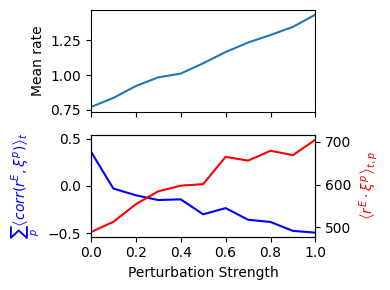

In [26]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
ax = [*ax, ax[1].twinx()]
ax[0].plot(perturb_param, list(map(lambda x: x[0].mean(), tests)))
ax[1].plot(perturb_param, list(map(lambda x: x.sum(axis=1).mean(), corrs)), 
           color='b', label='Corr.')
ax[2].plot(perturb_param, list(map(lambda x: x.mean(), ovlps)), 
           color='r', label='Overlap')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(xlabel='Perturbation Strength', xlim=perturb_param[[0,-1]], ylim=[-_, _])
ax[1].set_ylabel(r'$\sum_p\left\langle corr(r^E, \xi^p)\right\rangle_t$', c='b')
ax[2].set_ylabel(r'$\left\langle r^E \cdot \xi^p\right\rangle_{t,p}$', c='r')
fig.tight_layout()